In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import operator
import random
from sklearn import metrics

In [2]:
dataset = pd.read_csv('train.csv', delimiter=',', header=0)
dataset.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
dataset.isnull().sum(axis = 0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
def replaceNanWithMean(x):
    col_mean = np.nanmean(x, axis = 0)
    inds = np.where(np.isnan(x))
    res = x.copy()
    res[inds] = np.take(col_mean, inds[1])
    return res

def prepareDataSet(dataset):
    dataset = dataset.fillna({"Embarked": "S"})
    ord_enc = OrdinalEncoder()
    one_hot_enc = OneHotEncoder()
    dataset['sex_code'] = ord_enc.fit_transform(dataset[['Sex']])
    oe_enc = OneHotEncoder()
    oe_results = oe_enc.fit_transform(dataset[["Embarked"]])
    dataset = dataset.join(pd.DataFrame(oe_results.toarray(), columns=oe_enc.categories_))
    common_age = dataset['Age'].value_counts().index[0]
    dataset['Age'] = dataset['Age'].fillna(common_age)
    return dataset, common_age

def getFeaturesValues(dataset, hasSurvived = True, normalizeData = False):
    result = dataset.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
    if (hasSurvived):
        result = result.drop(['Survived'], axis=1)
    if (normalizeData):
        normalizeColumns = np.array(['Pclass','Age', 'SibSp', 'Parch', 'Fare'])
        scaler = StandardScaler()
        norm_vals = scaler.fit_transform(result[normalizeColumns].values)
        rest_data = result.drop(normalizeColumns, axis = 1)
        a = pd.DataFrame(norm_vals, columns = normalizeColumns)
        return rest_data.join(a), scaler
    return result

def getPredictions(dataset):
    return dataset['Survived']

In [11]:
preparedDataSet, common_age = prepareDataSet(dataset)
y_df = getPredictions(preparedDataSet)
x_df, scaler = getFeaturesValues(preparedDataSet, normalizeData = True)
x_df.isnull().sum(axis = 0)

sex_code    0
(C,)        0
(Q,)        0
(S,)        0
Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_df.values, y_df.values, test_size=0.2)

In [ ]:
models_euclid = []
models_manhattan = []
models_minkowski = []

In [43]:
def learnModels(min_k,max_k,  weight, norm):
    models = []
    for i in range(min_k, max_k+1):
        knn = KNeighborsClassifier(n_neighbors=i, weights=weight, metric = norm)
        knn.fit(x_train, y_train)
        models.append(knn)
    return models

def getAccuracyArr(models, x_test, y_test):
    res = []
    for model in models:
        res.append(metrics.accuracy_score(y_test, model.predict(x_test)))
    return res

In [65]:
min_k = 1
max_k = 15
models_euclid = learnModels(min_k, max_k, 'uniform', 'euclidean')
models_manhattan = learnModels(min_k, max_k, 'uniform', 'manhattan') 
models_minkowski = learnModels(min_k, max_k, 'uniform', 'minkowski')

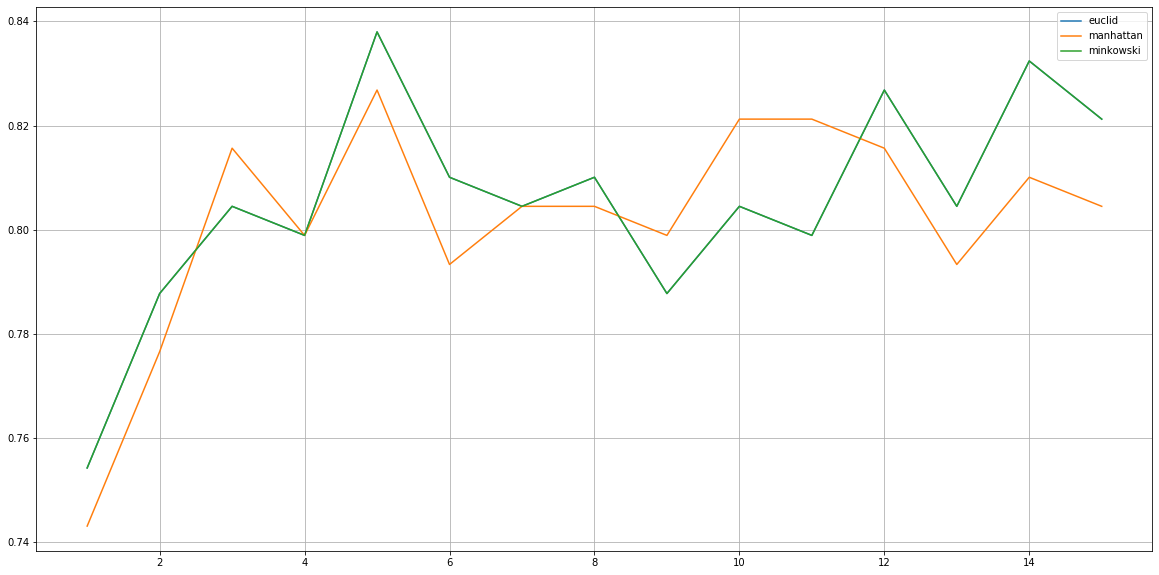

In [66]:
fig, ax1 = plt.subplots(1, 1,figsize=(20,10))



ax1.plot(np.arange(min_k, max_k+1), getAccuracyArr(models_euclid, x_test, y_test), label = 'euclid')
ax1.plot(np.arange(min_k, max_k+1), getAccuracyArr(models_manhattan, x_test, y_test), label = 'manhattan')
ax1.plot(np.arange(min_k, max_k+1), getAccuracyArr(models_minkowski, x_test, y_test), label = 'minkowski')
ax1.legend()
ax1.set_yscale('linear')
ax1.grid(True)



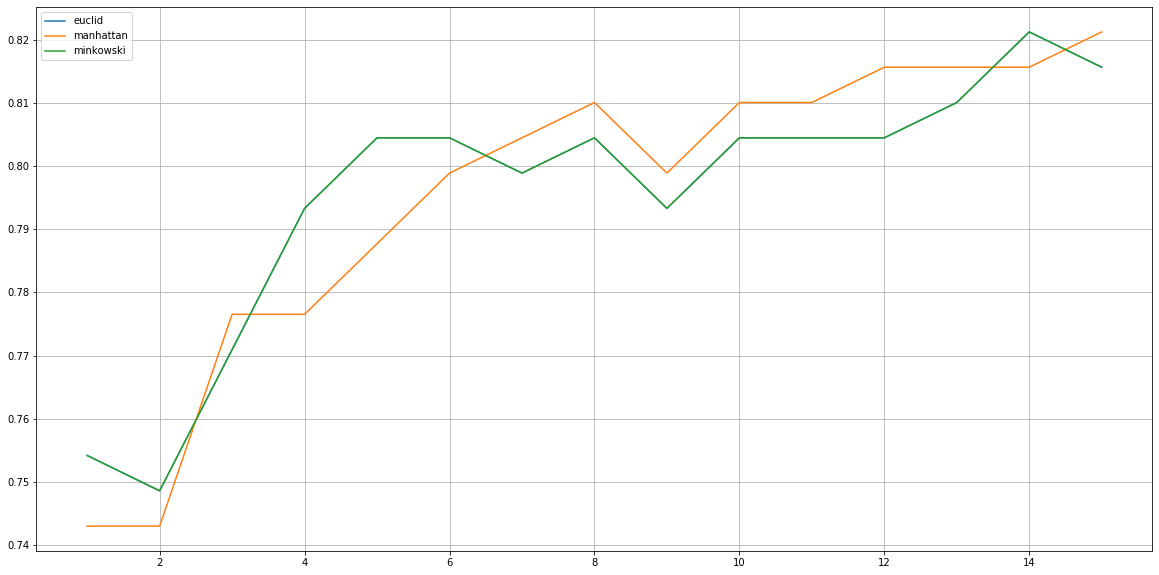

In [67]:
min_k = 1
max_k = 15
models_euclid = learnModels(min_k, max_k, 'distance', 'euclidean')
models_manhattan = learnModels(min_k, max_k, 'distance', 'manhattan') 
models_minkowski = learnModels(min_k, max_k, 'distance', 'minkowski')

fig, ax1 = plt.subplots(1, 1,figsize=(20,10))



ax1.plot(np.arange(min_k, max_k+1), getAccuracyArr(models_euclid, x_test, y_test), label = 'euclid')
ax1.plot(np.arange(min_k, max_k+1), getAccuracyArr(models_manhattan, x_test, y_test), label = 'manhattan')
ax1.plot(np.arange(min_k, max_k+1), getAccuracyArr(models_minkowski, x_test, y_test), label = 'minkowski')
ax1.legend()
ax1.set_yscale('linear')
ax1.grid(True)



In [69]:
best_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric = 'minkowski')
final_res = best_model.fit(x_train, y_train)
print(metrics.accuracy_score(y_test, final_res.predict(x_test)))

0.8379888268156425
